# Lecture 22 – Data 100, Spring 2025

Data 100, Spring 2025

[Acknowledgments Page](https://ds100.org/sp25/acks/)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 3
sns.set()

from scipy.optimize import minimize

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.linear_model as lm
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In this lecture, we will work with the `basketball` dataset, which contains information about basketball games played in the NBA. In the cell below, we perform data cleaning to transform the data into a useful form, which we store as the DataFrame `games`. 

Our goal in this portion of the lecture is to predict whether or not a team wins their game (`"WON"`) given their `"GOAL_DIFF"`. The variable `"GOAL_DIFF"` represents the difference in successful field goal rates between the two teams competing in a game. A positive value for `"GOAL_DIFF"` means that a team made more field goals than their opponent; a negative value means that the opponent made more field goals.

In [3]:
basketball = pd.read_csv("data/nba.csv")

one_team = basketball.groupby("GAME_ID").first()
opponent = basketball.groupby("GAME_ID").last()
games = one_team.merge(opponent, left_index = True, right_index = True, suffixes = ["", "_OPP"])
games['GOAL_DIFF'] = games["FG_PCT"] - games["FG_PCT_OPP"]
games['WON'] = games['WL'].replace('L', 0).replace('W', 1)
games = games[['TEAM_NAME', 'MATCHUP', 'WON', 'GOAL_DIFF']]
games

,TEAM_NAME,MATCHUP,WON,GOAL_DIFF
GAME_ID,,,,
21700001,Boston Celtics,BOS @ CLE,0,-0.049
21700002,Golden State Warriors,GSW vs. HOU,0,0.053
21700003,Charlotte Hornets,CHA @ DET,0,-0.030
21700004,Indiana Pacers,IND vs. BKN,1,0.041
21700005,Orlando Magic,ORL vs. MIA,1,0.042
...,...,...,...,...
21701226,New Orleans Pelicans,NOP vs. SAS,1,0.189
21701227,Oklahoma City Thunder,OKC vs. MEM,1,0.069
21701228,LA Clippers,LAC vs. LAL,0,0.017


## Logistic Regression

If we visualize our data, we see a very different result from the scatter plots we have been working with for linear regression. Because a team can only win or lose a game, the only possible values of `"WON"` are 1 (if the team won the game) or 0 (if the team lost).

<Axes: xlabel='GOAL_DIFF', ylabel='WON'>

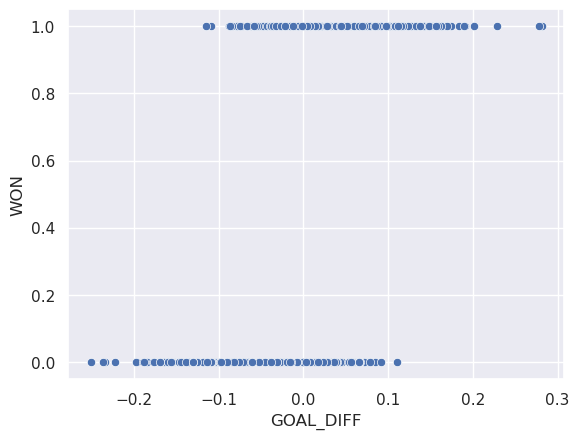

In [4]:
# Creating scatterplot on the games DF using two columns GOAL_DIFF and WON
# sns.scatterplot(data=games, x="GOAL_DIFF", y="WON")

...

Because the only possible values of `"WON"` are 0 or 1, there is significant overplotting in the visualization above. We can use `sns.stripplot` to jitter the $y$ data by adding a small amount of random noise. This makes it easier to interpret the plot. It also gives us nice colors for 0 and 1.

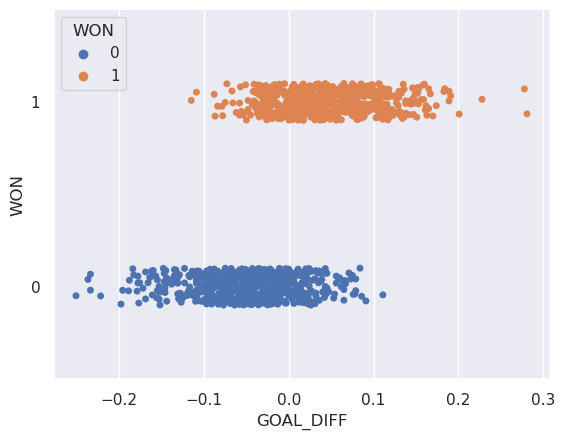

In [5]:
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", order=[1, 0], hue="WON");

Least squares linear regression, which is intended to output *continuous* numeric predictions, works poorly here (perhaps unsurprisingly).

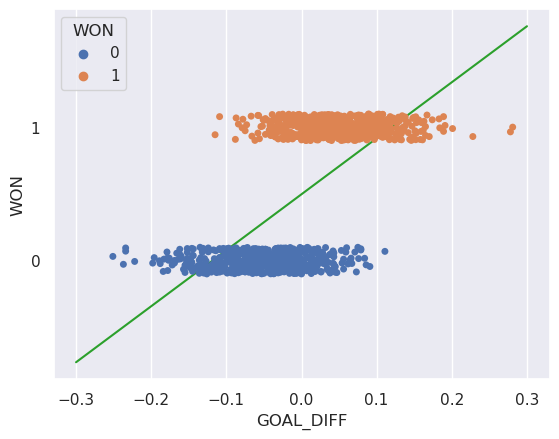

In [6]:
X = games[["GOAL_DIFF"]]
Y = games["WON"]

least_squares_model = lm.LinearRegression()
least_squares_model.fit(X, Y)

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", hue="WON")
xs = np.linspace(-0.3, 0.3)
plt.plot(xs, least_squares_model.predict(xs[:, np.newaxis]), c="tab:green")
plt.gca().invert_yaxis();

The least squares linear regression won't work here. We will need a new approach to modeling.

Back in Data 8, you built up your understanding of linear regression by first considering the [graph of averages](https://inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column.html#example-prediction). We construct a graph of averages by *binning* all $x$ data into bins of similar values, then computing the average value of $y$ for each bin. This gives us a rough indication of the relationship between $x$ and $y$.

Let's try this on our dataset.

In [7]:
bins = pd.cut(games["GOAL_DIFF"], 20)
games["bin"] = [(b.left + b.right) / 2 for b in bins]
win_rates_by_bin = games.groupby("bin")["WON"].mean()
# win_rates_by_bin
...

bin
-0.2380    0.000000
-0.2110    0.000000
-0.1845    0.000000
-0.1580    0.000000
-0.1315    0.000000
-0.1047    0.033898
-0.0781    0.083333
-0.0515    0.148438
-0.0249    0.363636
 0.0017    0.505747
 0.0283    0.705128
 0.0549    0.792793
 0.0815    0.907407
 0.1079    0.984615
 0.1345    1.000000
 0.1615    1.000000
 0.1880    1.000000
 0.2410    1.000000
 0.2675    1.000000
Name: WON, dtype: float64

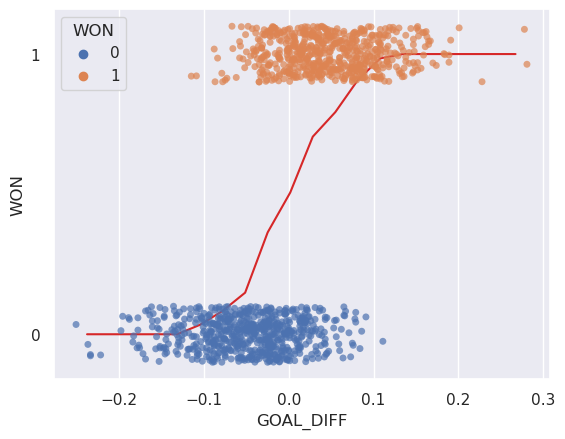

In [8]:
# alpha makes the points transparent so we can see the curve more clearly.
sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.7, hue="WON")
plt.plot(win_rates_by_bin.index, win_rates_by_bin, c="tab:red")
plt.gca().invert_yaxis();

Our graph of averages has revealed a S-shaped curve. This doesn't look like anything we've encountered before!

The relationship between $x$ (`"GOAL_DIFF"`) and $y$ (`"WON"`) shows clear non-linearity. To apply the linear modeling techniques we've explored previously, we will need to *linearize* the relationship. Recall our previous approach to transforming variables:

1. Apply transformations to linearize the relationship between our variables of interest.
2. Fit a linear regression model to the transformed data.
3. "Un-transform" our data to recover the underlying relationship between the original variables.

First, we need to decide what transformations we will perform. The S-shaped curve above doesn't resemble our bulge diagram, so we must apply a new transformation to linearize the relationship.

To determine what this transformation should be, we make a few observations:
* All predictions on our curve are between 0 and 1.
* To compute the average for each bin, we calculated: $\frac{\#\:Y=1\:\text{in bin}}{\#\:\text{datapoints in bin}} = P(Y=1 | \text{bin})$.

Together, these observations indicate that our graph of averages is *actually* modeling the probability of a data point having $Y = 1$! Rather than predict any continuous numeric output, we now want to predict the *probability* of a datapoint belonging to Class 1 (i.e., the team winning the game). 

To determine if it is "likely" that a data point belongs to Class 1, we can consider the **odds**: 

$$\text{odds} = \frac{P(Y=1|x)}{P(Y=0|x)} = \frac{P(Y=1|x)}{1-P(Y=1|x)} = \frac{p}{1-p}$$

Here, we use $p$ to denote the probability of a datapoint belonging to Class 1. A large odds value means that it is more likely than not that the data point belongs to Class 1.

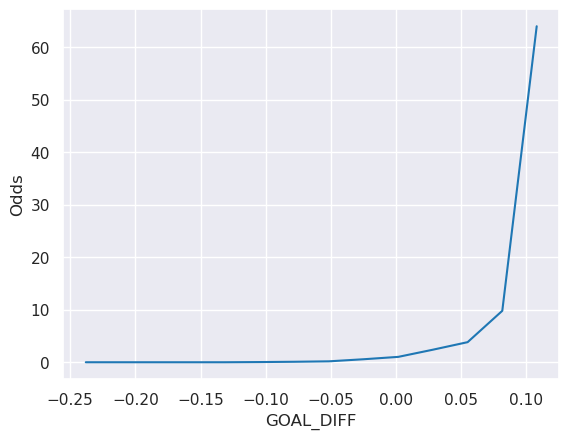

In [9]:
odds = win_rates_by_bin/(1-win_rates_by_bin)

plt.plot(odds.index, odds, c="tab:blue")
plt.xlabel("GOAL_DIFF")
plt.ylabel("Odds");

Interesting – the relationship between the odds and our `"GOAL_DIFF"` feature appears exponential. Let's "undo" this exponential trend by taking the logarithm.

As a reminder, you should always assume that any logarithm in Data 100 is base $e$ (the natural log) unless told otherwise.

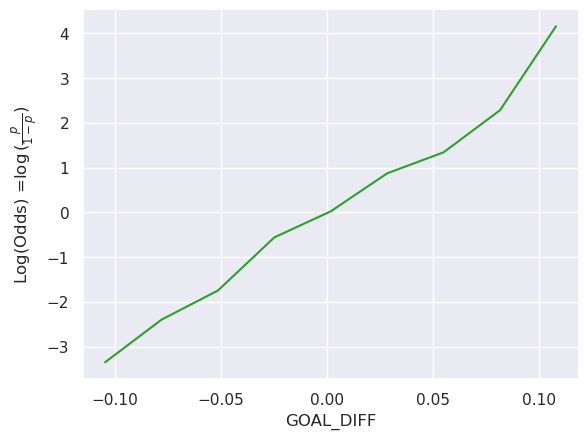

In [10]:
log_odds = np.log(odds)

plt.plot(log_odds.index, log_odds, c="tab:green")
plt.xlabel("GOAL_DIFF")
plt.ylabel(r"Log(Odds) =$\log{(\frac{p}{1-p})}$");

We've found a linear relationship! It turns out that the logarithm of the odds shares a linear relationship with our `"GOAL_DIFF"` feature. This means that we can express the log odds as a linear combination of the features:

$$\log{(\frac{p}{1-p})}=x^T \theta$$

Now, we can "undo" our transformations to recover the underlying relationship between the `"GOAL_DIFF"` and the probability of the datapoint belonging to Class 1. In the work below, $x^T$ represents the row vector containing all features for the $i$th datapoint. We can express our linear regression fit as a linear combination of the model parameters, $x^T \theta$.

$$\begin{align}
x^T \theta &= \log{\frac{p}{1-p}}\\
e^{x^T \theta} &= \frac{p}{1-p}\\
(1-p)e^{x^T \theta} &= p\\
e^{x^T \theta}- p e^{x^T \theta} &= p\\
e^{x^T \theta} &= p(1 + e^{x^T \theta})\\
p &= \frac{e^{x^T \theta}}{1+e^{x^T \theta}}\\
p &= \frac{1}{1+e^{-x^T \theta}}\\
\end{align}$$

Hence, the model's output – the predicted probability that the $i$-th datapoint belongs to Class 1, is given by:

$$\hat{y} = P(Y=1|x_i) = \frac{1}{1+e^{-x_i^T \theta}}$$

The expression $\frac{1}{1+e^{-z}}$ is known as the **sigmoid** function, and typically represented as $\sigma(z)$. We can therefore equivalently express our model as $\hat{y} = P(Y=1|x) = \sigma(x^T \theta)$. This model is known as the **logistic regression model**.

When we fit a logistic regression model to our data, we produce the S-shaped curve generated by the graph of averages!

In [ ]:
logistic_model = lm.LogisticRegression(C=20)
logistic_model.fit(X, Y)
predicted_prob = logistic_model.predict_proba(xs[:, np.newaxis])[:, 1]

sns.stripplot(data=games, x="GOAL_DIFF", y="WON", orient="h", alpha=0.5, hue="WON", legend=None)
plt.plot(xs, predicted_prob, c="k", lw=3, label="Logistic regression model")
plt.plot(win_rates_by_bin.index, win_rates_by_bin, lw=2, c="tab:red", label="Graph of averages")
plt.legend(loc="upper left")
plt.gca().invert_yaxis();

## Cross-Entropy Loss

To select model parameters for our logistic regression model, we will need to choose a loss function. We might be inclined to use our familiar mean squared error. It turns out this is a bad idea.

In the cell below, we artificially generate a "toy" dataset to play with as we explore the loss of a logistic regression model. We'll try to use the `"x"` feature to predict the `"y"` target.

In [11]:
toy_df = pd.DataFrame({
        "x": [-4, -2, -0.5, 1, 3, 5],
        "y": [0, 0, 1, 0, 1, 1]
})
toy_df.sort_values("x")

,x,y
0,-4.0,0
1,-2.0,0
2,-0.5,1
3,1.0,0
4,3.0,1
5,5.0,1


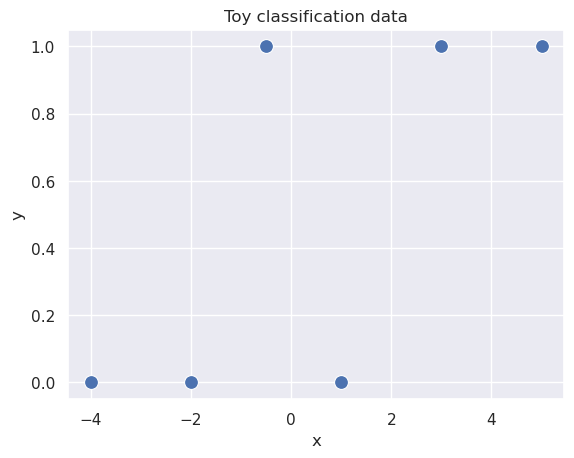

In [12]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100)
plt.title("Toy classification data");

Let's plot the loss surface for this toy data using MSE with the model $\hat{y} = \sigma(x.\theta)$. We don't include an intercept term, so $\theta$ and $x$ are both scalars.

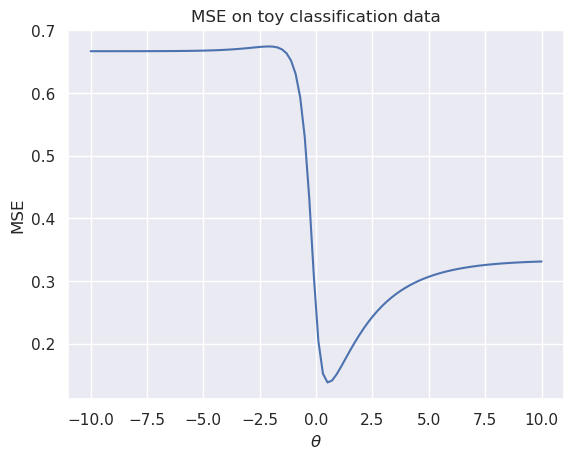

In [13]:
def sigmoid(z):
    return 1/(1+np.e**-z)

def mse_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean((toy_df['y'] - p_hat)**2)

thetas = np.linspace(-10, 10, 100)
plt.plot(thetas, [mse_on_toy_data(theta) for theta in thetas])
plt.title("MSE on toy classification data")
plt.xlabel(r'$\theta$')
plt.ylabel('MSE');

This loss surface is not convex! There are both local and global minima in the loss surface. This means that, depending on where we start our optimization search, we'll end up with different results for the optimizing $\theta$. Let's explore with `scipy.optimize.minimize`.

In [14]:
# Set the initial guess as theta = 0
best_theta = minimize(mse_on_toy_data, x0 = 0)["x"][0]
best_theta

0.5446601825581691

This "optimized" value of $\theta$ produces the following model when we apply it to our model $\hat{y} = \sigma(\theta x )$.

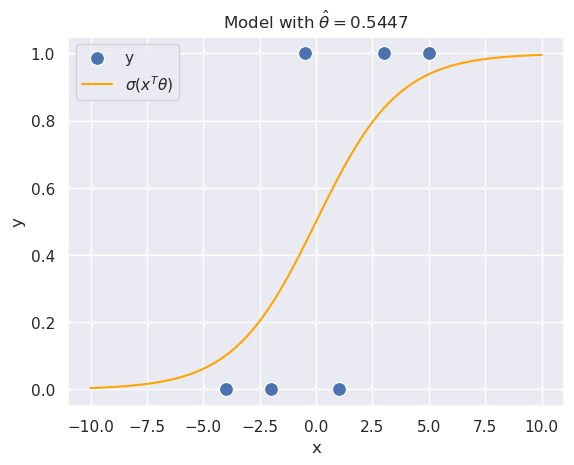

In [15]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigmoid(xs * best_theta), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title("Model with " + r'$\hat{\theta} = $' + f"{best_theta:.4}");

Let's try a different starting point for the initial guess for the minimizing parameter value.

In [16]:
# Set the initial guess as theta = -5
best_theta_2 = minimize(mse_on_toy_data, x0 = -5)["x"][0]
best_theta_2

-10.343653061026611

Uh oh, looks like the optimizer got stuck at a local minimum of the loss surface. If we use this guess for the optimal $\theta$ in our logistic regression model, we see strange behavior.

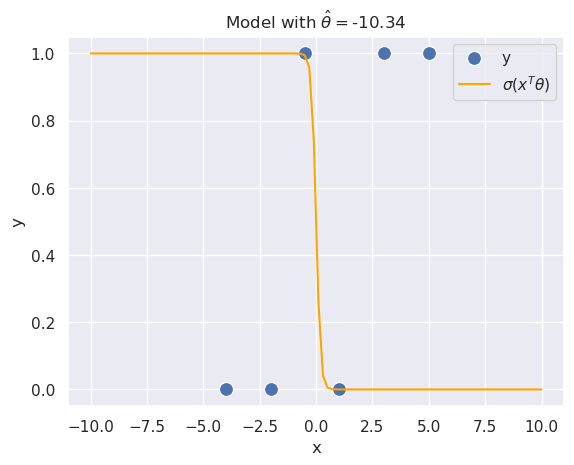

In [17]:
sns.scatterplot(data=toy_df, x='x', y='y', s=100, label='y')
xs = np.linspace(-10, 10, 100)
plt.plot(xs, sigmoid(xs * best_theta_2), color='orange', label=r'$\sigma(x^T \theta)$')
plt.xlabel('x')
plt.legend()
plt.title("Model with " + r'$\hat{\theta} = $' + f"{best_theta_2:.4}");

To see what went wrong, let's plot these two "optimized" guess for $\hat{\theta}$ on the original loss surface. They correspond to the local and global minimum of the loss surface.

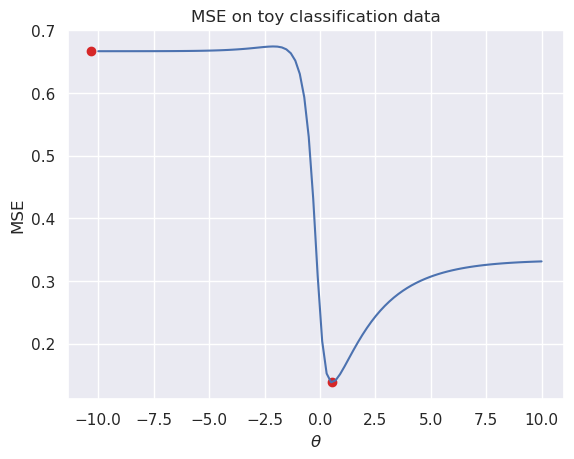

In [18]:
plt.plot(thetas, [mse_on_toy_data(theta) for theta in thetas])
plt.scatter([best_theta, best_theta_2], [mse_on_toy_data(best_theta), mse_on_toy_data(best_theta_2)], c="tab:red")
plt.title("MSE on toy classification data")
plt.xlabel(r'$\theta$')
plt.ylabel('MSE');

We've seen now that the fact that MSE is not convex for logistic regression leads to difficulty in optimizing $\hat{\theta}$. 

Beyond this issue, the squared loss isn't well-suited for a probability task. Since $\hat{p}_i$ is between 0 and 1, and $y_i$ is either 0 or 1, the squared loss for a single point $(y_i - \hat{p}_i)^2$ is bounded between 0 and 1.

What this means in practice: even if our prediction is terrible, the squared loss is never that large. Consider the "worst-case scenario" where the true class $y_i$ of datapoint $i$ is 0, and the model predicts a probability $p_i=1$ that this datapoint belongs to Class 1. Even though our model has made the worst possible prediction, the squared loss is only $(0-1)^2=1$!

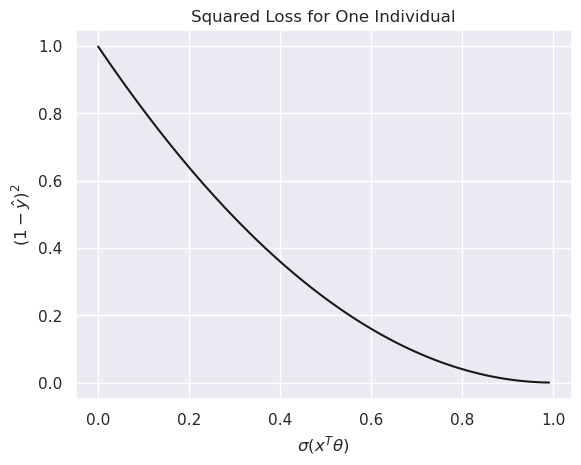

In [19]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = (1 - p_hat)**2
plt.plot(p_hat, loss, color='k')
plt.xlabel(r'$\sigma({x^T \theta})$')
plt.ylabel(r'$(1 - \hat{y})^2$')
plt.title('Squared Loss for One Individual');

### Motivating Cross-Entropy Loss

Let's look at a new loss, called the **negative log loss**, for when our true observation is 1. We define the loss on a single datapoint as $l = -\log{p}$.

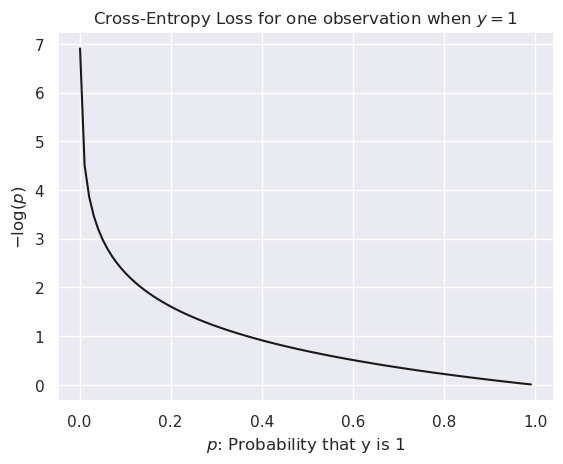

In [20]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 1$');

We can see that this penalizes wrong predictions far more than squared loss does.

How to read this plot: suppose the observation we're trying to predict is actually in Class 1. If our model gives an 80% chance of being in Class 1, the loss is relatively small (around 0.25). 

* If we predict only a 40% chance of being in Class 1, the loss is larger (around 1).
* If we predict only a 5% chance of being in Class 1, the loss is 3.
* And if we give a 0% chance of being in Class 1, the loss is infinite.

What about when the true observation is 0? Consider the single-datapoint loss given by $l=-\log{(1-p)}$.

In [ ]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(1 - p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$p$: Probability that y is 1')
plt.ylabel('$-\log(1 - p)$')
plt.title('Cross-Entropy Loss for one observation when $y = 0$');

Much of the formal derivation is in the slides. The equation for cross-entropy loss for a single observation is:

$$\textrm{loss} = -y \log(\hat{y}) - (1-y)\log(1-\hat{y}) = -(y \log(\hat{y}) + (1-y)\log(1-\hat{y}))$$

For us, since $\hat{y} = \sigma(x^T \theta)$, the expression for average cross-entropy loss is:

$$R(\theta) = -\frac{1}{n} \sum_{i = 1}^n \big(y_i \log (\sigma(\mathbb{X}_i^T \theta)) + (1 - y_i) \log (1 - \sigma(\mathbb{X}_i^T \theta))\big)$$

Let's look at the loss surface for average cross-entropy loss on our toy data from before.

In [21]:
def cross_entropy(y, p_hat):
    return - y * np.log(p_hat) - (1 - y) * np.log(1 - p_hat)

In [22]:
def mean_cross_entropy_on_toy_data(theta):
    p_hat = sigmoid(toy_df['x'] * theta)
    return np.mean(cross_entropy(toy_df['y'], p_hat))

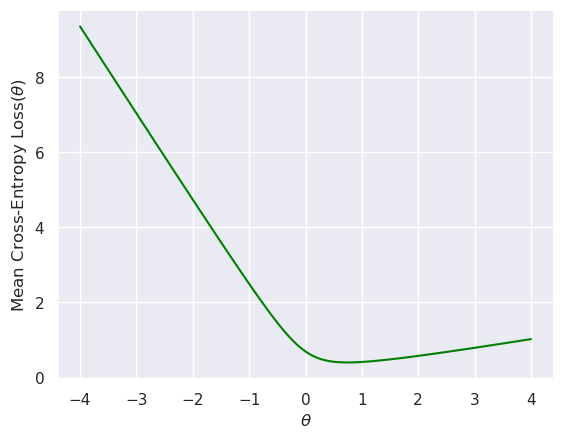

In [23]:
thetas = np.linspace(-4, 4, 100)
plt.plot(thetas, [mean_cross_entropy_on_toy_data(theta) for theta in thetas], color = 'green')
plt.ylabel(r'Mean Cross-Entropy Loss($\theta$)')
plt.xlabel(r'$\theta$');